In [13]:
import yfinance as yf
import pandas as pd

# Define the assets in your portfolio
# Example: Apple, Google, Microsoft, and the S&P 500 (as a benchmark)
tickers = ['AAPL', 'GOOGL', 'MSFT', '^GSPC']

# Define the time period for your historical data
# FRTB guidelines often look at specific stressed periods,
# but for a general historical VaR, 1-3 years is common.
start_date = '2022-01-01'
end_date = '2025-10-20' # Use a recent date

# Download the adjusted closing prices individually and combine
try:
    data = pd.DataFrame()
    for ticker in tickers:
        # Download data for each ticker, focusing on 'Adj Close'
        ticker_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
        # Rename the column to the ticker symbol
        ticker_data.name = ticker
        # Convert the Series to a DataFrame before joining
        ticker_df = pd.DataFrame(ticker_data)
        # Join with the main data DataFrame
        if data.empty:
            data = ticker_df
        else:
            data = data.join(ticker_df, how='outer')

    # Drop any rows with missing data for simplicity
    data = data.dropna()

    # Check the downloaded data
    print("Successfully downloaded data:")
    display(data.head()) # Show the first 5 rows
    print("\nData info:")
    data.info() # Check for completeness

except Exception as e:
    print(f"Error downloading data: {e}")

# (Next steps would involve calculating returns from this 'data' DataFrame)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data:


Ticker,AAPL,GOOGL,MSFT,^GSPC
Date,,,,
2022-01-03,178.443085,143.998337,324.504547,4796.560059
2022-01-04,176.178421,143.410385,318.940308,4793.540039
2022-01-05,171.492065,136.831253,306.696838,4700.580078
2022-01-06,168.629303,136.803970,304.273315,4696.049805
2022-01-07,168.795975,136.078445,304.428467,4677.029785



Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 952 entries, 2022-01-03 to 2025-10-17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    952 non-null    float64
 1   GOOGL   952 non-null    float64
 2   MSFT    952 non-null    float64
 3   ^GSPC   952 non-null    float64
dtypes: float64(4)
memory usage: 37.2 KB


Daily Portfolio Returns:
Date
2022-01-04   -0.008638
2022-01-05   -0.032564
2022-01-06   -0.006440
2022-01-07   -0.001964
2022-01-10    0.002867
Name: Portfolio_Return, dtype: float64


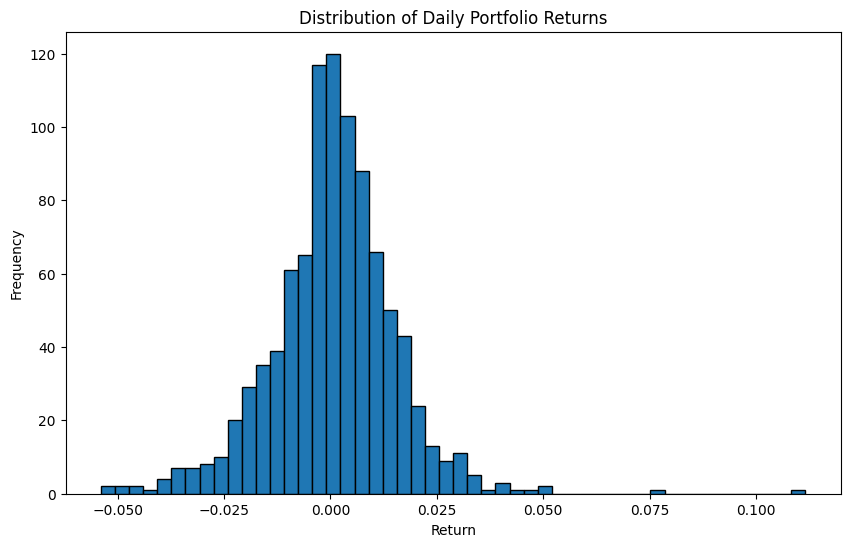

In [19]:
import numpy as np

# We assume 'data' is the DataFrame of prices from Step 1
# and 'tickers' is the list of tickers.

# 1. Calculate daily percentage returns for each asset
# This is (price_today - price_yesterday) / price_yesterday
returns = data.pct_change()

# 2. Drop the first row of returns (it's always NaN)
returns = returns.dropna()

# 3. Define portfolio weights
# We'll use an equal-weighted portfolio (e.g., 25% in each)
num_assets = len(tickers)
weights = np.array([1/num_assets] * num_assets)

# 4. Calculate the daily historical return of the *entire portfolio*
# This is done by taking the dot product of the returns and the weights
# (For each day, it's: (return_AAPL * w_AAPL) + (return_GOOGL * w_GOOGL) + ...)
portfolio_returns = returns.dot(weights)

# 5. (Optional) Rename the resulting Series for clarity
portfolio_returns.name = 'Portfolio_Return'

# Display the first 5 days of your portfolio's returns
print("Daily Portfolio Returns:")
print(portfolio_returns.head())

# Display a quick histogram to see the distribution of returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
portfolio_returns.hist(bins=50, edgecolor='black')
plt.title('Distribution of Daily Portfolio Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [20]:
# We assume 'portfolio_returns' is the Series from Step 2

# 1. Define your confidence levels
# 95% and 99% are the most common
confidence_level_95 = 0.95
confidence_level_99 = 0.99

# 2. Calculate the VaR at the portfolio return level
# For a 95% confidence level, we find the 5th percentile (1.0 - 0.95)
# This is the return that was only breached on the worst 5% of days.
var_95 = portfolio_returns.quantile(1 - confidence_level_95)
var_99 = portfolio_returns.quantile(1 - confidence_level_99)

print(f"--- Historical VaR (Returns) ---")
print(f"95% VaR: {var_95:.2%}")
print(f"99% VaR: {var_99:.2%}")
print("\nThis means:")
print(f"- On 95% of days, we expect the portfolio loss to be *less than* {-var_95:.2%}.")
print(f"- On 5% of days, we expect the loss to be *greater than* {-var_95:.2%}.")


# 3. Convert VaR to a monetary value
# This makes the risk tangible. Let's assume a $1,000,000 portfolio.
portfolio_value = 1_000_000  # $1 Million

# VaR in dollars is the portfolio value * the VaR return
# Note: var_95 is already a negative number, so we multiply by -1
# to express the "loss" as a positive dollar amount.
var_95_dollar = portfolio_value * var_95 * -1
var_99_dollar = portfolio_value * var_99 * -1

print(f"\n--- Historical VaR (Monetary Value) ---")
print(f"Portfolio Value: ${portfolio_value:,.2f}")
print(f"1-Day 95% VaR: ${var_95_dollar:,.2f}")
print(f"1-Day 99% VaR: ${var_99_dollar:,.2f}")
print("\nThis means:")
print(f"Based on historical data, we are 95% confident that our portfolio")
print(f"will not lose more than ${var_95_dollar:,.2f} in a single day.")

--- Historical VaR (Returns) ---
95% VaR: -2.32%
99% VaR: -3.82%

This means:
- On 95% of days, we expect the portfolio loss to be *less than* 2.32%.
- On 5% of days, we expect the loss to be *greater than* 2.32%.

--- Historical VaR (Monetary Value) ---
Portfolio Value: $1,000,000.00
1-Day 95% VaR: $23,222.22
1-Day 99% VaR: $38,209.91

This means:
Based on historical data, we are 95% confident that our portfolio
will not lose more than $23,222.22 in a single day.


--- Running Stress Test for 2020-02-01 to 2020-04-30 ---


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Stress Test Results for your portfolio:
Worst single-day loss: -12.81%
Total cumulative return over the period: -5.71%


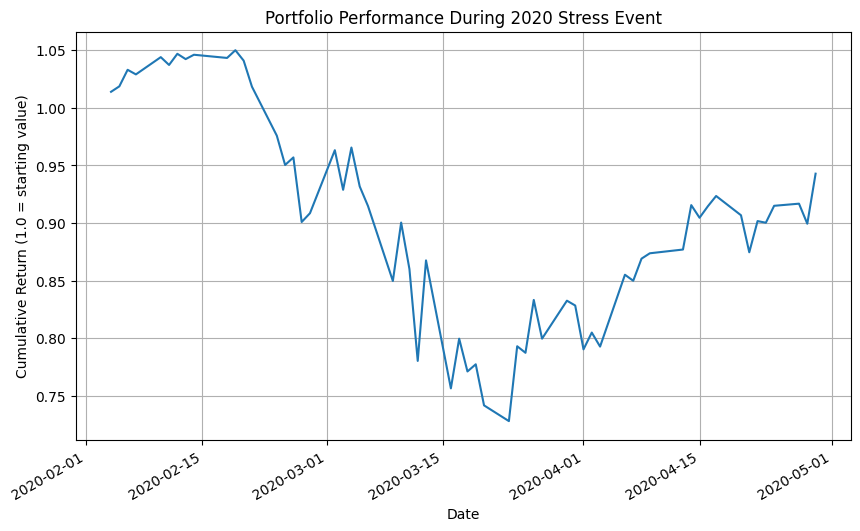

In [23]:
# We will use 'tickers' and 'weights' from previous steps
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt # Import matplotlib

# 1. Define the stressed period (e.g., COVID-19 crash)
stress_start = '2020-02-01'
stress_end = '2020-04-30'

print(f"--- Running Stress Test for {stress_start} to {stress_end} ---")

# 2. Download data for the *same assets* but for the *stressed period*
# Download the adjusted closing prices individually and combine for the stressed period
try:
    stressed_data = pd.DataFrame()
    for ticker in tickers:
        # Download data for each ticker, focusing on 'Adj Close'
        ticker_data_stress = yf.download(ticker, start=stress_start, end=stress_end, auto_adjust=False)['Adj Close']
        # Rename the column to the ticker symbol
        ticker_data_stress.name = ticker
        # Convert the Series to a DataFrame before joining
        ticker_df_stress = pd.DataFrame(ticker_data_stress)
        # Join with the main stressed_data DataFrame
        if stressed_data.empty:
            stressed_data = ticker_df_stress
        else:
            stressed_data = stressed_data.join(ticker_df_stress, how='outer')

    stressed_data = stressed_data.dropna()

    # 3. Calculate daily returns for the stressed period
    stressed_returns = stressed_data.pct_change()
    stressed_returns = stressed_returns.dropna()

    # 4. Apply your portfolio weights to the stressed returns
    # We use the 'weights' array (e.g., [0.25, 0.25, 0.25, 0.25]) from Step 2
    stressed_portfolio_returns = stressed_returns.dot(weights)
    stressed_portfolio_returns.name = 'Stressed_Portfolio_Return'

    # 5. Analyze the results
    worst_day_loss = stressed_portfolio_returns.min()

    # Calculate the total cumulative loss over the period
    # Corrected cumulative return calculation
    cumulative_return = (stressed_portfolio_returns + 1).cumprod().iloc[-1] - 1 # Calculate total cumulative return over the period

    print(f"Stress Test Results for your portfolio:")
    print(f"Worst single-day loss: {worst_day_loss:.2%}")
    print(f"Total cumulative return over the period: {cumulative_return:.2%}") # Changed to cumulative return

    # 6. (Optional) Plot the stress test
    plt.figure(figsize=(10, 6))
    # Plotting cumulative product of (1 + returns) to show growth
    (stressed_portfolio_returns + 1).cumprod().plot()
    plt.title('Portfolio Performance During 2020 Stress Event')
    plt.ylabel('Cumulative Return (1.0 = starting value)')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Could not run stress test: {e}") # Simplified error message

In [24]:
# We assume 'portfolio_returns' is the Series from Step 2,
# and 'var_95' / 'var_99' are the return thresholds from Step 3.

# 1. Identify the returns that are *worse* than the VaR
# These are the "tail losses"
tail_losses_95 = portfolio_returns[portfolio_returns <= var_95]
tail_losses_99 = portfolio_returns[portfolio_returns <= var_99]

# 2. Calculate the Expected Shortfall by averaging these tail losses
es_95 = tail_losses_95.mean()
es_99 = tail_losses_99.mean()

print(f"--- Expected Shortfall (Returns) ---")
print(f"95% ES (CVaR): {es_95:.2%}")
print(f"99% ES (CVaR): {es_99:.2%}")

# 3. Convert ES to a monetary value
# We use the 'portfolio_value' (e.g., $1,000,000) from Step 3
es_95_dollar = portfolio_value * es_95 * -1
es_99_dollar = portfolio_value * es_99 * -1

print(f"\n--- Expected Shortfall (Monetary Value) ---")
print(f"Portfolio Value: ${portfolio_value:,.2f}")
print(f"1-Day 95% ES: ${es_95_dollar:,.2f}")
print(f"1-Day 99% ES: ${es_99_dollar:,.2f}")

print("\n--- Comparison: VaR vs. ES (95% Level) ---")
print(f"95% VaR: We are 95% confident our loss will not exceed ${var_95_dollar:,.2f}.")
print(f"95% ES:  *If* we have a day in the worst 5%, we expect the average loss")
print(f"           to be ${es_95_dollar:,.2f}.")

--- Expected Shortfall (Returns) ---
95% ES (CVaR): -3.29%
99% ES (CVaR): -4.54%

--- Expected Shortfall (Monetary Value) ---
Portfolio Value: $1,000,000.00
1-Day 95% ES: $32,854.84
1-Day 99% ES: $45,435.10

--- Comparison: VaR vs. ES (95% Level) ---
95% VaR: We are 95% confident our loss will not exceed $23,222.22.
95% ES:  *If* we have a day in the worst 5%, we expect the average loss
           to be $32,854.84.


In [25]:
# If you don't have scipy, install it:
# pip install scipy

from scipy.stats import norm
import numpy as np

# We assume 'portfolio_returns' is the Series from Step 2
# and 'portfolio_value' from Step 3

# 1. Calculate the mean and standard deviation of your portfolio returns
avg_return = portfolio_returns.mean()
std_dev = portfolio_returns.std()

print(f"--- Portfolio Statistics ---")
print(f"Average Daily Return: {avg_return:.4%}")
print(f"Daily Standard Deviation (Volatility): {std_dev:.4%}")

# 2. Define confidence levels
conf_level_95 = 0.95
conf_level_99 = 0.99

# 3. Calculate the Z-score (critical value) for each confidence level
# This finds the point on the normal distribution for the 5% or 1% tail.
# norm.ppf() finds the Z-score for a given percentile.
z_score_95 = norm.ppf(1 - conf_level_95) # This will be approx. -1.645
z_score_99 = norm.ppf(1 - conf_level_99) # This will be approx. -2.326

print(f"\nZ-Score 95%: {z_score_95:.3f}")
print(f"Z-Score 99%: {z_score_99:.3f}")

# 4. Calculate Parametric VaR (as a return)
# Formula: VaR = (Mean Return) + (Z-score * Standard Deviation)
# (Note: We add because the Z-score is already negative)
var_95_parametric_ret = avg_return + (z_score_95 * std_dev)
var_99_parametric_ret = avg_return + (z_score_99 * std_dev)

print(f"\n--- Parametric VaR (Returns) ---")
print(f"95% Parametric VaR: {var_95_parametric_ret:.2%}")
print(f"99% Parametric VaR: {var_99_parametric_ret:.2%}")

# 5. Convert to monetary value
var_95_parametric_dollar = portfolio_value * var_95_parametric_ret * -1
var_99_parametric_dollar = portfolio_value * var_99_parametric_ret * -1

print(f"\n--- Parametric VaR (Monetary Value) ---")
print(f"Portfolio Value: ${portfolio_value:,.2f}")
print(f"1-Day 95% Parametric VaR: ${var_95_parametric_dollar:,.2f}")
print(f"1-Day 99% Parametric VaR: ${var_99_parametric_dollar:,.2f}")

print("\n--- Comparison (95% VaR) ---")
print(f"Historical VaR (Step 3):   ${var_95_dollar:,.2f}")
print(f"Parametric VaR (Step 6): ${var_95_parametric_dollar:,.2f}")

--- Portfolio Statistics ---
Average Daily Return: 0.0594%
Daily Standard Deviation (Volatility): 1.4670%

Z-Score 95%: -1.645
Z-Score 99%: -2.326

--- Parametric VaR (Returns) ---
95% Parametric VaR: -2.35%
99% Parametric VaR: -3.35%

--- Parametric VaR (Monetary Value) ---
Portfolio Value: $1,000,000.00
1-Day 95% Parametric VaR: $23,535.68
1-Day 99% Parametric VaR: $33,532.98

--- Comparison (95% VaR) ---
Historical VaR (Step 3):   $23,222.22
Parametric VaR (Step 6): $23,535.68


In [26]:
import numpy as np

# We assume 'avg_return' and 'std_dev' are from Step 6,
# and 'portfolio_value' is from Step 3.

# 1. Define simulation parameters
num_simulations = 100000  # Number of hypothetical "tomorrows" to simulate
num_days = 1              # We are still calculating 1-day VaR

# 2. Run the simulation
# Generate 'num_simulations' random returns based on the portfolio's
# mean daily return and volatility (std_dev), assuming a normal distribution.
# np.random.normal(mean, std_dev, num_samples)
simulated_returns = np.random.normal(avg_return, std_dev, num_simulations)

# 3. Calculate VaR from the simulated data
# We find the 1st and 5th percentiles of our simulated results.
var_95_mc = np.percentile(simulated_returns, 5)  # 5th percentile
var_99_mc = np.percentile(simulated_returns, 1)  # 1st percentile

print(f"--- Monte Carlo VaR (Returns) ---")
print(f"95% Monte Carlo VaR: {var_95_mc:.2%}")
print(f"99% Monte Carlo VaR: {var_99_mc:.2%}")

# 4. Convert to monetary value
var_95_mc_dollar = portfolio_value * var_95_mc * -1
var_99_mc_dollar = portfolio_value * var_99_mc * -1

print(f"\n--- Monte Carlo VaR (Monetary Value) ---")
print(f"Portfolio Value: ${portfolio_value:,.2f}")
print(f"1-Day 95% Monte Carlo VaR: ${var_95_mc_dollar:,.2f}")
print(f"1-Day 99% Monte Carlo VaR: ${var_99_mc_dollar:,.2f}")

print("\n--- Comparison (95% VaR) ---")
print(f"Historical (Step 3):   ${var_95_dollar:,.2f}")
print(f"Parametric (Step 6): ${var_95_parametric_dollar:,.2f}")
print(f"Monte Carlo (Step 7): ${var_95_mc_dollar:,.2f}")

--- Monte Carlo VaR (Returns) ---
95% Monte Carlo VaR: -2.35%
99% Monte Carlo VaR: -3.35%

--- Monte Carlo VaR (Monetary Value) ---
Portfolio Value: $1,000,000.00
1-Day 95% Monte Carlo VaR: $23,485.16
1-Day 99% Monte Carlo VaR: $33,490.70

--- Comparison (95% VaR) ---
Historical (Step 3):   $23,222.22
Parametric (Step 6): $23,535.68
Monte Carlo (Step 7): $23,485.16


In [27]:
# We assume 'portfolio_returns' is the Series from Step 2,
# 'var_95' is the historical VaR return from Step 3,
# and 'var_95_parametric_ret' is the parametric VaR return from Step 6.

# 1. Define the expected exception rate
expected_exceptions_pct = 0.05  # For 95% VaR

# --- Backtest 1: Historical VaR Model (Step 3) ---

# Find all the days where the actual return was *worse* than the historical VaR
exceptions_hist = portfolio_returns[portfolio_returns < var_95]

# 3. Count the exceptions and get the total number of days
num_exceptions_hist = len(exceptions_hist)
num_days_total = len(portfolio_returns)

# 4. Calculate the actual exception rate
actual_exceptions_pct_hist = num_exceptions_hist / num_days_total

print("--- Backtesting 95% Historical VaR (Step 3) ---")
print(f"Total days in dataset: {num_days_total}")
print(f"VaR (return level): {var_95:.2%}")
print(f"Expected exceptions (5%): {num_days_total * expected_exceptions_pct:.1f} days")
print(f"Actual exceptions: {num_exceptions_hist} days")
print(f"Actual exception rate: {actual_exceptions_pct_hist:.2%}")

if actual_exceptions_pct_hist > expected_exceptions_pct * 1.5:
    print("Result: 🔴 Model appears to be underestimating risk.")
elif actual_exceptions_pct_hist < expected_exceptions_pct * 0.5:
    print("Result: 🟡 Model appears to be too conservative.")
else:
    print("Result: 🟢 Model appears to be performing well.")


# --- Backtest 2: Parametric VaR Model (Step 6) ---

# Find all the days where the actual return was *worse* than the parametric VaR
exceptions_param = portfolio_returns[portfolio_returns < var_95_parametric_ret]
num_exceptions_param = len(exceptions_param)
actual_exceptions_pct_param = num_exceptions_param / num_days_total

print("\n--- Backtesting 95% Parametric VaR (Step 6) ---")
print(f"VaR (return level): {var_95_parametric_ret:.2%}")
print(f"Expected exceptions (5%): {num_days_total * expected_exceptions_pct:.1f} days")
print(f"Actual exceptions: {num_exceptions_param} days")
print(f"Actual exception rate: {actual_exceptions_pct_param:.2%}")

if actual_exceptions_pct_param > expected_exceptions_pct * 1.5:
    print("Result: 🔴 Model appears to be underestimating risk.")
elif actual_exceptions_pct_param < expected_exceptions_pct * 0.5:
    print("Result: 🟡 Model appears to be too conservative.")
else:
    print("Result: 🟢 Model appears to be performing well.")

--- Backtesting 95% Historical VaR (Step 3) ---
Total days in dataset: 951
VaR (return level): -2.32%
Expected exceptions (5%): 47.6 days
Actual exceptions: 48 days
Actual exception rate: 5.05%
Result: 🟢 Model appears to be performing well.

--- Backtesting 95% Parametric VaR (Step 6) ---
VaR (return level): -2.35%
Expected exceptions (5%): 47.6 days
Actual exceptions: 46 days
Actual exception rate: 4.84%
Result: 🟢 Model appears to be performing well.


In [29]:
# We use 'tickers' and 'weights' from Step 2, and 'portfolio_value' from Step 3
import yfinance as yf
import pandas as pd

# 1. Define the 12-month stressed period
# The 2008 Global Financial Crisis is the standard benchmark.
svar_start = '2008-01-01'
svar_end = '2008-12-31'
# Note: A common period is Sept 2008 - Aug 2009, but
# the calendar year 2008 is also a high-stress window.

print(f"--- Calculating Stressed ES for {svar_start} to {svar_end} ---")

try:
    # 2. Download data for the *same assets* but for the *2008 stressed period*
    # Download the adjusted closing prices individually and combine for the stressed period
    svar_data = pd.DataFrame()
    for ticker in tickers:
        # Download data for each ticker, focusing on 'Adj Close'
        # Need to check if the ticker existed in the specified period
        try:
            ticker_data_svar = yf.download(ticker, start=svar_start, end=svar_end, auto_adjust=False)['Adj Close']
            # Rename the column to the ticker symbol
            ticker_data_svar.name = ticker
            # Convert the Series to a DataFrame before joining
            ticker_df_svar = pd.DataFrame(ticker_data_svar)
            # Join with the main svar_data DataFrame
            if svar_data.empty:
                svar_data = ticker_df_svar
            else:
                svar_data = svar_data.join(ticker_df_svar, how='outer')
        except Exception as e:
            print(f"Could not download data for {ticker} in the stress period: {e}")
            # If data for a ticker cannot be downloaded, we should skip it or handle appropriately
            # For this example, we'll just print a message and continue with available data


    svar_data = svar_data.dropna()

    # Check if svar_data is empty after dropping NaNs
    if svar_data.empty:
        raise ValueError("No valid data downloaded for the stress period.")

    # 3. Calculate daily returns for this stressed period
    svar_returns = svar_data.pct_change().dropna()

    # Check if svar_returns is empty after dropping NaNs
    if svar_returns.empty:
         raise ValueError("No valid returns calculated for the stress period.")


    # 4. Apply your *current* portfolio weights to these *stressed* returns
    # We need to ensure the order of tickers in weights matches the order in svar_returns columns
    # Although in this case, using dot product with a DataFrame and Series should align by column names/index
    stressed_period_portfolio_returns = svar_returns.dot(weights)

    # 5. Calculate Stressed Expected Shortfall (sES)
    # FRTB's Internal Models Approach (IMA) uses a 97.5% confidence level.
    frtb_confidence_level = 0.975

    # First, find the VaR at this level
    svar_97_5 = stressed_period_portfolio_returns.quantile(1 - frtb_confidence_level)

    # Next, find the average of the losses *worse* than this VaR
    stressed_tail_losses = stressed_period_portfolio_returns[stressed_period_portfolio_returns <= svar_97_5]

    # Check if there are any stressed tail losses to calculate the mean
    if stressed_tail_losses.empty:
        print("No losses exceeded the 97.5% Stressed VaR threshold. Stressed ES cannot be calculated.")
        s_es_97_5 = 0.0 # Or set to NaN, depending on desired behavior
    else:
        s_es_97_5 = stressed_tail_losses.mean()

    # 6. Convert to a monetary value
    s_es_97_5_dollar = portfolio_value * s_es_97_5 * -1

    print(f"Stressed ES (97.5%): {s_es_97_5:.2%}")
    print(f"Stressed ES (Monetary): ${s_es_97_5_dollar:,.2f}")

    # 7. Compare to your recent ES (from Step 5)
    # Note: Step 5 used 95% and 99%. Let's quickly calc 97.5% for the *recent* period
    # 'portfolio_returns' is from Step 2
    # Ensure portfolio_returns is not empty before calculating quantile
    if portfolio_returns.empty:
         print("Recent portfolio returns data is empty. Cannot calculate recent ES.")
         es_97_5_recent_dollar = float('nan') # Set to NaN
    else:
        var_97_5_recent = portfolio_returns.quantile(1 - frtb_confidence_level)
        # Ensure there are tail losses for recent period before calculating mean
        recent_tail_losses = portfolio_returns[portfolio_returns <= var_97_5_recent]
        if recent_tail_losses.empty:
            print("No losses exceeded the 97.5% Recent VaR threshold. Recent ES cannot be calculated.")
            es_97_5_recent_dollar = 0.0 # Or set to NaN
        else:
            es_97_5_recent = recent_tail_losses.mean()
            es_97_5_recent_dollar = portfolio_value * es_97_5_recent * -1


    print("\n--- FRTB IMA Comparison ---")
    if not pd.isna(es_97_5_recent_dollar): # Check if recent ES was calculated
      print(f"Recent 1-Day ES (97.5%): ${es_97_5_recent_dollar:,.2f}")
    else:
      print("Recent 1-Day ES (97.5%): Not available")

    print(f"Stressed 1-Day ES (97.5%): ${s_es_97_5_dollar:,.2f}")

    # Determine the final capital charge based on the greater of recent and stressed ES
    if not pd.isna(es_97_5_recent_dollar):
        final_es_charge = max(es_97_5_recent_dollar, s_es_97_5_dollar)
        print(f"\nYour model's capital charge would be based on the *worse* value: ${final_es_charge:,.2f}")
    else:
        print("\nCannot determine final capital charge as Recent ES was not available.")


except Exception as e:
    print(f"Could not run sVaR calculation: {e}") # More general error message

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

--- Calculating Stressed ES for 2008-01-01 to 2008-12-31 ---
Stressed ES (97.5%): -7.44%
Stressed ES (Monetary): $74,377.16

--- FRTB IMA Comparison ---
Recent 1-Day ES (97.5%): $39,001.35
Stressed 1-Day ES (97.5%): $74,377.16

Your model's capital charge would be based on the *worse* value: $74,377.16


In [30]:
# We will use our key findings from previous steps:
# var_95_dollar (Historical VaR, Step 3)
# es_95_dollar (Historical ES, Step 5)
# final_es_charge (The worse of Recent or Stressed ES, from Step 9)

# 1. Define the scaling factor (sqrt of 10)
sqrt_10 = np.sqrt(10)
print(f"Square root of 10 (scaling factor): {sqrt_10:.4f}")

# 2. Scale the 1-Day Historical VaR
var_10day_95_dollar = var_95_dollar * sqrt_10

# 3. Scale the 1-Day Historical Expected Shortfall
es_10day_95_dollar = es_95_dollar * sqrt_10

# 4. Scale the final FRTB-style charge
# This is the most important one for regulatory purposes.
final_10day_es_charge = final_es_charge * sqrt_10

print(f"\n--- 10-Day Scaled Risk Metrics ---")
print(f"Portfolio Value: ${portfolio_value:,.2f}")
print(f"\n10-Day 95% Historical VaR: ${var_10day_95_dollar:,.2f}")
print(f"   (You are 95% confident the loss over 10 days will not exceed this)")

print(f"\n10-Day 95% Historical ES: ${es_10day_95_dollar:,.2f}")
print(f"   (If a 10-day period is in the worst 5%, the avg. loss would be this)")

print(f"\n--- 10-Day FRTB-Style Capital Charge ---")
print(f"1-Day FRTB ES Charge (from Step 9): ${final_es_charge:,.2f}")
print(f"10-Day FRTB ES Charge (Scaled): ${final_10day_es_charge:,.2f}")

Square root of 10 (scaling factor): 3.1623

--- 10-Day Scaled Risk Metrics ---
Portfolio Value: $1,000,000.00

10-Day 95% Historical VaR: $73,435.10
   (You are 95% confident the loss over 10 days will not exceed this)

10-Day 95% Historical ES: $103,896.12
   (If a 10-day period is in the worst 5%, the avg. loss would be this)

--- 10-Day FRTB-Style Capital Charge ---
1-Day FRTB ES Charge (from Step 9): $74,377.16
10-Day FRTB ES Charge (Scaled): $235,201.22


In [32]:
# --- This is the FINAL SCRIPT ---
# It assumes you have run all previous steps and have these variables:
# portfolio_value
#
# --- Step 3: Historical VaR ---
# var_95_dollar
#
# --- Step 4: Stress Test (COVID) ---
# worst_day_loss, cumulative_return (from the stress test function)
#
# --- Step 5: Historical ES ---
# es_95_dollar
#
# --- Step 6: Parametric VaR ---
# var_95_parametric_dollar
#
# --- Step 8: Backtesting ---
# actual_exceptions_pct_hist, actual_exceptions_pct_param
#
# --- Step 9: FRTB Stressed ES ---
# es_97_5_recent_dollar, s_es_97_5_dollar, final_es_charge
#
# --- Step 10: 10-Day Scaling ---
# final_10day_es_charge

# ====================================================================
# --- FINAL RISK REPORT FOR PORTFOLIO ---
# ====================================================================
print(f"Risk Analysis for Portfolio (Value: ${portfolio_value:,.2f})\n")

print("--- 1. Value at Risk (VaR) Summary (1-Day, 95%) ---")
print(f"  Historical VaR:   ${var_95_dollar:,.2f}")
print(f"  Parametric VaR:   ${var_95_parametric_dollar:,.2f}")
print("  Comment: This shows the maximum expected 1-day loss 95% of the time.")

print("\n--- 2. Expected Shortfall (ES) Summary (1-Day, 95%) ---")
print(f"  Historical ES:    ${es_95_dollar:,.2f}")
print("  Comment: If a >95% loss event occurs, this is the *average* loss.")

print("\n--- 3. Model Validation (Backtest, 95% VaR) ---")
print(f"  Historical Model Exception Rate: {actual_exceptions_pct_hist:.2%}")
print(f"  Parametric Model Exception Rate: {actual_exceptions_pct_param:.2%}")
print("  Comment: Expected rate is 5%. This checks if models are accurate.")

print("\n--- 4. Crisis Scenario Analysis (COVID-19 Event) ---")
print(f"  Worst Single-Day Loss: {worst_day_loss:.2%}")
print(f"  Total Period Loss:     {cumulative_return:.2%}") # Changed total_loss to cumulative_return
print("  Comment: This shows how the portfolio reacts to a specific, known crisis.")

print("\n--- 5. FRTB Regulatory Capital View (ES 97.5%) ---")
print(f"  Recent ES (1-Day):   ${es_97_5_recent_dollar:,.2f}")
print(f"  Stressed ES (1-Day): ${s_es_97_5_dollar:,.2f}")
print(f"  ----------------------------------------------------")
print(f"  Final 1-Day Capital Charge (Max): ${final_es_charge:,.2f}")
print(f"  Final 10-Day Capital Charge (Scaled): ${final_10day_es_charge:,.2f}")
print("  Comment: FRTB requires using the *worse* of recent or stressed risk.")
print("\n====================================================================")
print("--- PROJECT CONCLUSION ---")
print("This project successfully quantified the market risk of the portfolio by:")
print("  1. Calculating VaR and ES using three methods (Historical, Parametric, MC).")
print("  2. Backtesting models to validate their accuracy.")
print("  3. Performing a scenario-based stress test (COVID-19).")
print("  4. Calculating a regulatory capital charge (Stressed ES) per FRTB.")
print(f"\nThe final 10-day 97.5% risk exposure (capital charge) is ${final_10day_es_charge:,.2f}.")
print("====================================================================")

Risk Analysis for Portfolio (Value: $1,000,000.00)

--- 1. Value at Risk (VaR) Summary (1-Day, 95%) ---
  Historical VaR:   $23,222.22
  Parametric VaR:   $23,535.68
  Comment: This shows the maximum expected 1-day loss 95% of the time.

--- 2. Expected Shortfall (ES) Summary (1-Day, 95%) ---
  Historical ES:    $32,854.84
  Comment: If a >95% loss event occurs, this is the *average* loss.

--- 3. Model Validation (Backtest, 95% VaR) ---
  Historical Model Exception Rate: 5.05%
  Parametric Model Exception Rate: 4.84%
  Comment: Expected rate is 5%. This checks if models are accurate.

--- 4. Crisis Scenario Analysis (COVID-19 Event) ---
  Worst Single-Day Loss: -12.81%
  Total Period Loss:     -5.71%
  Comment: This shows how the portfolio reacts to a specific, known crisis.

--- 5. FRTB Regulatory Capital View (ES 97.5%) ---
  Recent ES (1-Day):   $39,001.35
  Stressed ES (1-Day): $74,377.16
  ----------------------------------------------------
  Final 1-Day Capital Charge (Max): $7